In [1]:
import numpy as np

from open_spiel.python import rl_environment
from open_spiel.python.pytorch import dqn as dqn_pt
from open_spiel.python.jax import dqn
from open_spiel.python.algorithms import random_agent

In [2]:
def eval_against_random_bots(env, trained_agents, random_agents, num_episodes):
  """Evaluates `trained_agents` against `random_agents` for `num_episodes`."""
  num_players = len(trained_agents)
  sum_episode_rewards = np.zeros(num_players)
  for player_pos in range(num_players):
    cur_agents = random_agents[:]
    cur_agents[player_pos] = trained_agents[player_pos]
    for _ in range(num_episodes):
      time_step = env.reset()
      episode_rewards = 0
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if env.is_turn_based:
          agent_output = cur_agents[player_id].step(
              time_step, is_evaluation=True)
          action_list = [agent_output.action]
        else:
          agents_output = [
              agent.step(time_step, is_evaluation=True) for agent in cur_agents
          ]
          action_list = [agent_output.action for agent_output in agents_output]
        time_step = env.step(action_list)
        episode_rewards += time_step.rewards[player_pos]
      sum_episode_rewards[player_pos] += episode_rewards
  return sum_episode_rewards / num_episodes

In [3]:
def pt_main(game,
            config,
            checkpoint_dir,
            num_train_episodes,
            eval_every,
            hidden_layers_sizes,
            replay_buffer_capacity,
            batch_size):
  num_players = 2

  env = rl_environment.Environment(game, **config)
  info_state_size = env.observation_spec()["info_state"][0]
  num_actions = env.action_spec()["num_actions"]

  # random agents for evaluation
  random_agents = [
      random_agent.RandomAgent(player_id=idx, num_actions=num_actions)
      for idx in range(num_players)
  ]


  hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
  # pylint: disable=g-complex-comprehension
  agents = [
      dqn_pt.DQN(
          player_id=idx,
          state_representation_size=info_state_size,
          num_actions=num_actions,
          hidden_layers_sizes=hidden_layers_sizes,
          replay_buffer_capacity=replay_buffer_capacity,
          batch_size=batch_size) for idx in range(num_players)
  ]
  result = []
  for ep in range(num_train_episodes):
    if (ep + 1) % eval_every == 0:
      r_mean = eval_against_random_bots(env, agents, random_agents, 1000)
      result.append(r_mean)
      print("[%s] Mean episode rewards %s" %(ep + 1, r_mean))

    time_step = env.reset()
    while not time_step.last():
      player_id = time_step.observations["current_player"]
      if env.is_turn_based:
        agent_output = agents[player_id].step(time_step)
        action_list = [agent_output.action]
      else:
        agents_output = [agent.step(time_step) for agent in agents]
        action_list = [agent_output.action for agent_output in agents_output]
      time_step = env.step(action_list)

    # Episode is over, step all agents with final info state.
    for agent in agents:
      agent.step(time_step)
  return result

In [5]:
def jax_main(game,
            config,
            checkpoint_dir,
            num_train_episodes,
            eval_every,
            hidden_layers_sizes,
            replay_buffer_capacity,batch_size):
  num_players = 2

  env = rl_environment.Environment(game, **config)
  info_state_size = env.observation_spec()["info_state"][0]
  num_actions = env.action_spec()["num_actions"]

  # random agents for evaluation
  random_agents = [
      random_agent.RandomAgent(player_id=idx, num_actions=num_actions)
      for idx in range(num_players)
  ]

  hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
  # pylint: disable=g-complex-comprehension
  agents = [
      dqn.DQN(
          player_id=idx,
          state_representation_size=info_state_size,
          num_actions=num_actions,
          hidden_layers_sizes=hidden_layers_sizes,
          replay_buffer_capacity=replay_buffer_capacity,
          batch_size=batch_size) for idx in range(num_players)
  ]

  result_jax = []
  for ep in range(num_train_episodes):
    if (ep + 1) % eval_every == 0:
      r_mean = eval_against_random_bots(env, agents, random_agents, 1000)
      result_jax.append(r_mean)
      print("[%s] Mean episode rewards %s" %(ep + 1, r_mean))

    time_step = env.reset()
    while not time_step.last():
      player_id = time_step.observations["current_player"]
      if env.is_turn_based:
        agent_output = agents[player_id].step(time_step)
        action_list = [agent_output.action]
      else:
        agents_output = [agent.step(time_step) for agent in agents]
        action_list = [agent_output.action for agent_output in agents_output]
      time_step = env.step(action_list)

    # Episode is over, step all agents with final info state.
    for agent in agents:
      agent.step(time_step)
  return result_jax

In [6]:
checkpoint_dir = "/tmp/dqn_test"
num_train_episodes = 10000
eval_every = 100

hidden_layers_sizes = [64, 64]
replay_buffer_capacity = int(1e5)
batch_size = 32

# BREAKTHROUGH

In [7]:
game = "breakthrough"
config = {"columns": 5, "rows": 5}

In [ ]:
pt_result = pt_main(    
    game,
    config,
    checkpoint_dir,
    num_train_episodes,
    eval_every,
    hidden_layers_sizes,
    replay_buffer_capacity,
    batch_size
)

[100] Mean episode rewards [0.238 0.042]
[200] Mean episode rewards [0.31  0.074]
[300] Mean episode rewards [ 0.29  -0.038]
[400] Mean episode rewards [0.296 0.04 ]
[500] Mean episode rewards [0.396 0.002]
[600] Mean episode rewards [0.288 0.032]
[700] Mean episode rewards [0.252 0.142]
[800] Mean episode rewards [0.262 0.126]
[900] Mean episode rewards [0.258 0.186]
[1000] Mean episode rewards [0.278 0.128]
[1100] Mean episode rewards [0.212 0.124]
[1200] Mean episode rewards [0.178 0.11 ]
[1300] Mean episode rewards [0.188 0.104]
[1400] Mean episode rewards [0.324 0.132]
[1500] Mean episode rewards [0.39 0.15]
[1600] Mean episode rewards [0.428 0.196]
[1700] Mean episode rewards [0.494 0.2  ]
[1800] Mean episode rewards [0.5   0.198]
[1900] Mean episode rewards [0.596 0.296]
[2000] Mean episode rewards [0.58 0.36]
[2100] Mean episode rewards [0.6   0.332]
[2200] Mean episode rewards [0.586 0.46 ]
[2300] Mean episode rewards [0.58 0.39]
[2400] Mean episode rewards [0.694 0.414]
[2500

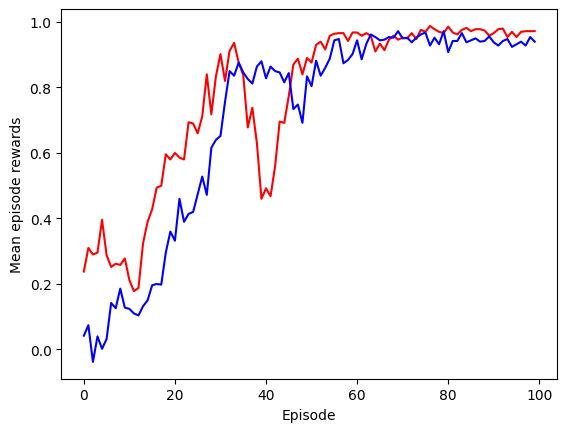

In [10]:
import matplotlib.pyplot as plt

ep = [x for x in range(len(pt_result))]
pt_r_mean0 = [y[0] for y in pt_result]
pt_r_mean1 = [y[1] for y in pt_result]

plt.plot(ep,pt_r_mean0, c='red')
plt.plot(ep,pt_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

In [ ]:
result_jax = jax_main(
    game,
    config,
    checkpoint_dir,
    num_train_episodes,
    eval_every,
    hidden_layers_sizes,
    replay_buffer_capacity,
    batch_size
)

[100] Mean episode rewards [0.192 0.068]
[200] Mean episode rewards [ 0.026 -0.052]
[300] Mean episode rewards [-0.182 -0.216]
[400] Mean episode rewards [-0.226 -0.328]
[500] Mean episode rewards [-0.294 -0.412]
[600] Mean episode rewards [-0.234 -0.402]
[700] Mean episode rewards [-0.308 -0.38 ]
[800] Mean episode rewards [-0.296 -0.382]


In [ ]:
ep = [x for x in range(len(result_jax))]
jax_r_mean0 = [y[0] for y in result_jax]
jax_r_mean1 = [y[1] for y in result_jax]

plt.plot(ep, jax_r_mean0, c='red')
plt.plot(ep, jax_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

NameError: name 'result_jax' is not defined

In [ ]:
plt.plot(ep,pt_r_mean0, c='skyblue')
plt.plot(ep,pt_r_mean1, c='skyblue', linestyle='dashed')
plt.plot(ep,tf_r_mean0, c='pink')
plt.plot(ep,tf_r_mean1, c='pink', linestyle='dashed')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

# TIC-TAC-TOE

In [9]:
game = "tic_tac_toe"
config = {}
num_train_episodes = 20000
eval_every = 1000

In [ ]:
pt_result = pt_main(
    game,
    config,
    checkpoint_dir,
    num_train_episodes,
    eval_every,
    hidden_layers_sizes,
    replay_buffer_capacity,
    batch_size
)

[1000] Mean episode rewards [0.823 0.112]
[2000] Mean episode rewards [0.769 0.089]
[3000] Mean episode rewards [0.883 0.161]
[4000] Mean episode rewards [0.723 0.229]
[5000] Mean episode rewards [0.424 0.125]
[6000] Mean episode rewards [0.54  0.246]
[7000] Mean episode rewards [0.637 0.244]
[8000] Mean episode rewards [0.794 0.236]
[9000] Mean episode rewards [0.643 0.148]
[10000] Mean episode rewards [0.813 0.148]
[11000] Mean episode rewards [0.626 0.17 ]
[12000] Mean episode rewards [0.622 0.188]
[13000] Mean episode rewards [0.874 0.244]
[14000] Mean episode rewards [0.856 0.183]
[15000] Mean episode rewards [0.825 0.28 ]
[16000] Mean episode rewards [0.82  0.361]
[17000] Mean episode rewards [0.847 0.241]
[18000] Mean episode rewards [0.869 0.296]
[19000] Mean episode rewards [0.904 0.261]
[20000] Mean episode rewards [0.858 0.277]


In [ ]:
import matplotlib.pyplot as plt

ep = [x for x in range(len(pt_result))]
pt_r_mean0 = [y[0] for y in pt_result]
pt_r_mean1 = [y[1] for y in pt_result]

plt.plot(ep,pt_r_mean0, c='red')
plt.plot(ep,pt_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

In [ ]:
result_jax = jax_main(
    game,
    config,
    checkpoint_dir,
    num_train_episodes,
    eval_every,
    hidden_layers_sizes,
    replay_buffer_capacity,
    batch_size
)

[1000] Mean episode rewards [ 0.493 -0.204]
[2000] Mean episode rewards [ 0.346 -0.244]
[3000] Mean episode rewards [ 0.537 -0.054]
[4000] Mean episode rewards [ 0.464 -0.059]
[5000] Mean episode rewards [0.46  0.144]
[6000] Mean episode rewards [0.442 0.08 ]
[7000] Mean episode rewards [0.606 0.068]
[8000] Mean episode rewards [0.447 0.165]
[9000] Mean episode rewards [0.702 0.196]
[10000] Mean episode rewards [0.694 0.227]
[11000] Mean episode rewards [0.757 0.213]
[12000] Mean episode rewards [0.829 0.149]
[13000] Mean episode rewards [0.733 0.186]
[14000] Mean episode rewards [0.8   0.318]
[15000] Mean episode rewards [0.849 0.308]
[16000] Mean episode rewards [0.789 0.198]
[17000] Mean episode rewards [0.825 0.353]
[18000] Mean episode rewards [0.804 0.367]
[19000] Mean episode rewards [0.827 0.355]
[20000] Mean episode rewards [0.796 0.368]


In [ ]:
ep = [x for x in range(len(result_jax))]
jax_r_mean0 = [y[0] for y in result_jax]
jax_r_mean1 = [y[1] for y in result_jax]

plt.plot(ep,jax_r_mean0, c='red')
plt.plot(ep,jax_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

In [ ]:
plt.plot(ep,pt_r_mean0, c='skyblue')
plt.plot(ep,pt_r_mean1, c='skyblue', linestyle='dashed')
plt.plot(ep,tf_r_mean0, c='pink')
plt.plot(ep,tf_r_mean1, c='pink', linestyle='dashed')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()